In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'similarity_matrix_combined_vhpc'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from itertools import product

In [7]:
post_animals = 'c18m9','vNAc7','99b','94', '94b', '96', '100', '98', '98b', '99', '104', '104b'

In [8]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [9]:
sessions = 'post',
comparison_labels='consumed','run_CSm','run_AA'
#only going to analyze .5s and 1s bins here to save time.
bins = ['05s','1s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14]


In [10]:
for tb in bins:
    for sess in sessions:
        try:
            exec("patterns_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

In [11]:
#need to downsample to minimum trial # out of the 3 trial types across all animals
min_trials={}
kept_animals=[]
for ani in patterns_1s_post.keys():
    min = np.min([sum(labels_post[ani]==5),sum(labels_post[ani]==6),sum(labels_post[ani]==7)])
    print ani, min
    min_trials[ani]=min
    if min > 25:
        kept_animals.extend([ani])
print kept_animals
grand_min=np.min([min_trials[ani] for ani in kept_animals])
print grand_min

104b 2
c18m9 33
99 14
98 8
vNAc7 33
99b 8
98b 26
100 36
94b 30
94 36
104 4
96 31
['c18m9', 'vNAc7', '98b', '100', '94b', '94', '96']
26


In [12]:
%%time
#combine cells and patterns across animals
for sess in sessions:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            for odor,trial in zip(comparison_labels,[5,6,7]):
                exec("combined_patterns_%s_%s_%s_%s=[]"%(tb,sess,t,odor))
                exec("combined_patterns_%s_%s_%s_%s = np.concatenate(([patterns_%s_%s[ani][t][labels_%s[ani]==trial][:grand_min-1]\
                  for ani in kept_animals]),axis=1)"%(tb,sess,t,odor,tb,sess,sess))


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.4 ms


In [13]:
%%time
#this will get correlations for each animal individually...no, it won't because lumped all data together above
odors= 'consumed','run_CSm','run_AA'
t = range(14)
pattern_ids_1s_post = ['1s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]

all_patterns_1s_post = [eval('combined_patterns_1s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_1s_post, all_patterns_1s_post)
across_tb_1s_res_post=corrmat_distr
print 'post DONE!',

## DO NO TRY THE BELOW: doesn't iterate over tt
#tb='1s'
#t=range(14)
#for sess in 'expo',:
#        exec("all_patterns_%s_%s = [combined_patterns_%s_%s_%s_%s for tt,odor in product(t,odors)]"%(tb,sess,tb,sess,tt,odor))
#        corrmat_distr, corrmat = ut.compute_similarity_matrix(eval("pattern_ids_%s_%s"%(tb,sess)), eval("all_patterns_%s_%s"%(tb,sess)))
#        exec("across_tb_%s_res_%s=corrmat_distr"%(tb,sess))
#        print '%s DONE!'%sess,

post DONE!CPU times: user 1min 5s, sys: 6.2 s, total: 1min 11s
Wall time: 1min 4s



In [14]:
%%time
t = range(29)
pattern_ids_05s_post = ['05s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]

all_patterns_05s_post = [eval('combined_patterns_05s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(pattern_ids_05s_post, all_patterns_05s_post)
across_tb_05s_res_post=corrmat_distr
print 'post DONE!',

post DONE!CPU times: user 4min 1s, sys: 25.2 s, total: 4min 27s
Wall time: 3min 59s



In [15]:
#make matrix of all comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess in sessions:
            for odor in odors:
                exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor,tb1))
                exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("matrix_%s_%s_%s_%s"%(tb,sess,odor,tb1)).insert(tb2,eval("np.mean(across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))
                    eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,tb1)).insert(tb2,eval("across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))

In [16]:
#make matrix of all across-odor comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'consumedvrun_CSm','consumedvrun_AA','run_CSmvrun_AA':
        for tb1 in range(bin_ranges[i]):
            for sess in sessions:
                    exec("matrix_%s_%s_%s_%s = []"%(tb,sess,odor_comp,tb1))
                    exec("matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor_comp,tb1))
                    for tb2 in range(bin_ranges[i]):
                        #get mean values across all animals
                        eval("matrix_%s_%s_%s_%s"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("np.mean(across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))
                        eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))

In [17]:
#get standard deviation and standard error for individual trial vs trial comparisons
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'consumedvrun_CSm','consumedvrun_AA','run_CSmvrun_AA':
        for t in range(bin_ranges[i]):
            for sess in sessions:
                exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("matrix_%s_%s_%s_%s_std.append(np.std(matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("matrix_%s_%s_%s_%s_err.append(np.std(matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [18]:
for tb,i in zip(bins,range(len(bins))):
    for sess in sessions:
        for trial in ['consumed','run_CSm','run_AA','consumedvrun_CSm','consumedvrun_AA','run_CSmvrun_AA']:
            exec("big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

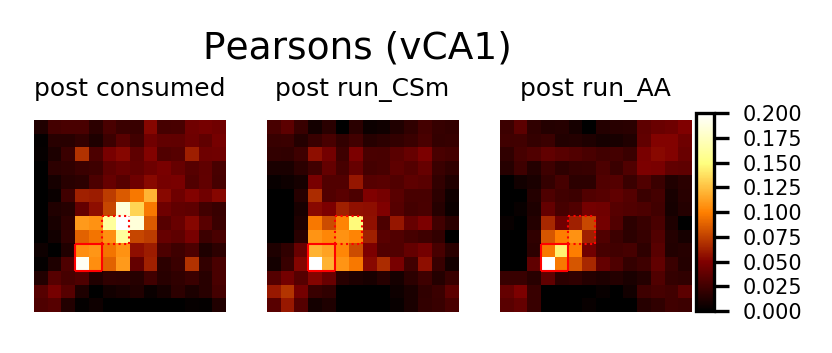

In [77]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(1,3,figsize=(2.4,1))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['consumed','run_CSm','run_AA'],[0,1,2]):
        im=axs[c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.2,cmap='afmhot')
        axs[c].set_title(sess+" "+trial,fontsize=6)
        axs[c].vlines(2.5,2.5,4.5,color='r')
        axs[c].hlines(2.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,2.5,4.5,color='r')
        axs[c].hlines(4.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].vlines(6.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(6.5,4.5,6.5,color='r',linestyle=':')
        pt.remove_axes(axs[c])
pl.suptitle('Pearsons (vCA1)',y=1.1,fontsize=9)
cax = fig.add_axes([.97, 0.163, 0.025, 0.66])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

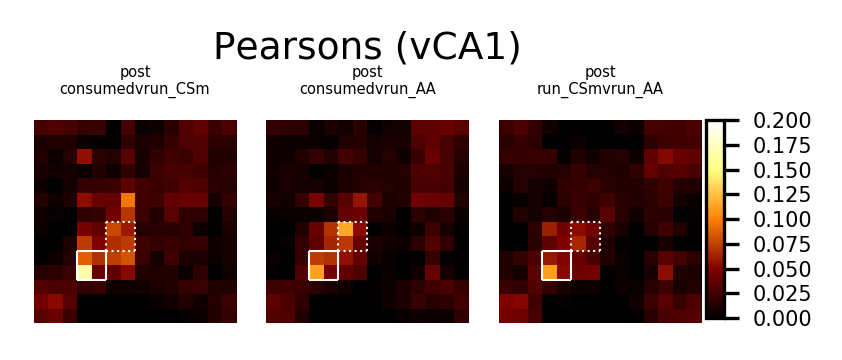

In [80]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(1,3,figsize=(2.4,1))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['consumedvrun_CSm','consumedvrun_AA','run_CSmvrun_AA'],[0,1,2]):
        im=axs[c].imshow(eval("big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.2,cmap='afmhot')
        axs[c].set_title(sess+"\n"+trial,fontsize=3.5)
        axs[c].vlines(2.5,2.5,4.5,color='w')
        axs[c].hlines(2.5,2.5,4.5,color='w')
        axs[c].vlines(4.5,2.5,4.5,color='w')
        axs[c].hlines(4.5,2.5,4.5,color='w')
        axs[c].vlines(4.5,4.5,6.5,color='w',linestyle=':')
        axs[c].hlines(4.5,4.5,6.5,color='w',linestyle=':')
        axs[c].vlines(6.5,4.5,6.5,color='w',linestyle=':')
        axs[c].hlines(6.5,4.5,6.5,color='w',linestyle=':')
        pt.remove_axes(axs[c])
pl.suptitle('Pearsons (vCA1)',y=1.1,fontsize=9)
cax = fig.add_axes([.97, 0.14, 0.025, 0.66])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

### use all trials, regardless of outcome (here only taking high performing animals, as in above)

In [21]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [22]:
#make a new label array, assigning new labels for each trial type
relabels = {1:10,4:10,5:10,2:11,6:11,3:12,7:12}

for sess in sessions:
    for tb in bins:
        try:
            exec("relabels_%s = {}"%sess)
            for ani in eval("%s_animals"%sess):
                exec("relabels_%s[ani] = np.r_[[relabels[l] for l in labels_%s[ani]]]"%(sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

In [23]:
%%time
#combine cells and patterns across animals
for sess in sessions:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            for odor,trial in zip(['rew','CSm','shock'],[10,11,12]):
                exec("allTs_combined_patterns_%s_%s_%s_%s=[]"%(tb,sess,t,odor))
                exec("allTs_combined_patterns_%s_%s_%s_%s = np.concatenate(([patterns_%s_%s[ani][t][relabels_%s[ani]==trial]\
                  for ani in kept_animals]),axis=1)"%(tb,sess,t,odor,tb,sess,sess))


CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 21.3 ms


In [28]:
%%time
#this will get correlations for each animal individually...no, it won't because lumped all data together above
odors= 'rew','CSm','shock'
t = range(14)
allTs_pattern_ids_1s_post = ['1s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]

allTs_all_patterns_1s_post = [eval('allTs_combined_patterns_1s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(allTs_pattern_ids_1s_post, allTs_all_patterns_1s_post)
allTs_across_tb_1s_res_post=corrmat_distr
print 'post DONE!',

post DONE!CPU times: user 3min 1s, sys: 16.4 s, total: 3min 18s
Wall time: 2min 59s



In [32]:
%%time
t = range(29)
allTs_pattern_ids_05s_post = ['05s_%s_%s_post'%(tt,odor) for tt, odor in product(t,odors)]

allTs_all_patterns_05s_post = [eval('allTs_combined_patterns_05s_post_%s_%s'%(tt,odor)) for tt,odor in product(t,odors)]
corrmat_distr, corrmat = ut.compute_similarity_matrix(allTs_pattern_ids_05s_post, allTs_all_patterns_05s_post)
allTs_across_tb_05s_res_post=corrmat_distr
print 'post DONE!',

post DONE!CPU times: user 10min 32s, sys: 1min 4s, total: 11min 36s
Wall time: 10min 24s



In [33]:
#make matrix of all comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for tb1 in range(bin_ranges[i]):
        for sess in sessions:
            for odor in odors:
                exec("allTs_matrix_%s_%s_%s_%s = []"%(tb,sess,odor,tb1))
                exec("allTs_matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor,tb1))
                for tb2 in range(bin_ranges[i]):
                    #get mean values across all animals
                    eval("allTs_matrix_%s_%s_%s_%s"%(tb,sess,odor,tb1)).insert(tb2,eval("np.mean(allTs_across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))
                    eval("allTs_matrix_%s_%s_%s_%s_all"%(tb,sess,odor,tb1)).insert(tb2,eval("allTs_across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                        "%(tb,sess,tb,tb1,odor,sess,tb,tb2,odor,sess,)))

In [34]:
#make matrix of all across-odor comparisons across tbs
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'rewvCSm','rewvshock','CSmvshock':
        for tb1 in range(bin_ranges[i]):
            for sess in sessions:
                    exec("allTs_matrix_%s_%s_%s_%s = []"%(tb,sess,odor_comp,tb1))
                    exec("allTs_matrix_%s_%s_%s_%s_all = []"%(tb,sess,odor_comp,tb1))
                    for tb2 in range(bin_ranges[i]):
                        #get mean values across all animals
                        eval("allTs_matrix_%s_%s_%s_%s"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("np.mean(allTs_across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s'])\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))
                        eval("allTs_matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,tb1)).insert(tb2,eval("allTs_across_tb_%s_res_%s['%s_%s_%s_%s','%s_%s_%s_%s']\
                            "%(tb,sess,tb,tb1,odor_comp.split('v')[0],sess,tb,tb2,odor_comp.split('v')[-1],sess)))

In [36]:
#get standard deviation and standard error for individual trial vs trial comparisons
import math
for tb,i in zip(bins,range(len(bins))):
    for odor_comp in 'rewvCSm','rewvshock','CSmvshock':
        for t in range(bin_ranges[i]):
            for sess in sessions:
                exec("allTs_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor_comp,t))
                exec("allTs_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor_comp,t))
                for x in range(len(eval("allTs_matrix_%s_%s_%s_%s_all"%(tb,sess,odor_comp,t)))):
                        exec("allTs_matrix_%s_%s_%s_%s_std.append(np.std(allTs_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                        exec("allTs_matrix_%s_%s_%s_%s_err.append(np.std(allTs_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(allTs_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor_comp,t,tb,sess,odor_comp,t,tb,sess,odor_comp,t))
                for odor in odors:
                    exec("allTs_matrix_%s_%s_%s_%s_std = []"%(tb,sess,odor,t))
                    exec("allTs_matrix_%s_%s_%s_%s_err = []"%(tb,sess,odor,t))
                    for x in range(len(eval("allTs_matrix_%s_%s_%s_%s_all"%(tb,sess,odor,t)))):
                        exec("allTs_matrix_%s_%s_%s_%s_std.append(np.std(allTs_matrix_%s_%s_%s_%s_all[x]))"%(tb,sess,odor,t,tb,sess,odor,t))
                        exec("allTs_matrix_%s_%s_%s_%s_err.append(np.std(allTs_matrix_%s_%s_%s_%s_all[x])/(math.sqrt(len(allTs_matrix_%s_%s_%s_%s_all[x]))))"%(tb,sess,odor,t,tb,sess,odor,t,tb,sess,odor,t))

In [37]:
for tb,i in zip(bins,range(len(bins))):
    for sess in sessions:
        for trial in ['rew','CSm','shock','rewvCSm','rewvshock','CSmvshock']:
            exec("allTs_big_matrix_%s_%s_%s = []"%(tb,sess,trial))
            for t in range(bin_ranges[i]):
                eval("allTs_big_matrix_%s_%s_%s"%(tb,sess,trial)).append(eval("allTs_matrix_%s_%s_%s_%s"%(tb,sess,trial,t)))

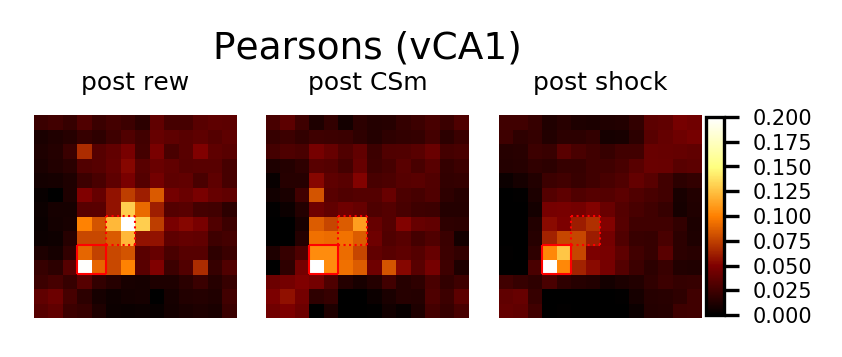

In [78]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(1,3,figsize=(2.4,1))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['rew','CSm','shock'],[0,1,2]):
        im=axs[c].imshow(eval("allTs_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.2,cmap='afmhot')
        axs[c].set_title(sess+" "+trial,fontsize=6)
        axs[c].vlines(2.5,2.5,4.5,color='r')
        axs[c].hlines(2.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,2.5,4.5,color='r')
        axs[c].hlines(4.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].vlines(6.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(6.5,4.5,6.5,color='r',linestyle=':')
        pt.remove_axes(axs[c])
pl.suptitle('Pearsons (vCA1)',y=1.1,fontsize=9)
cax = fig.add_axes([.97, 0.15, 0.025, 0.66])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

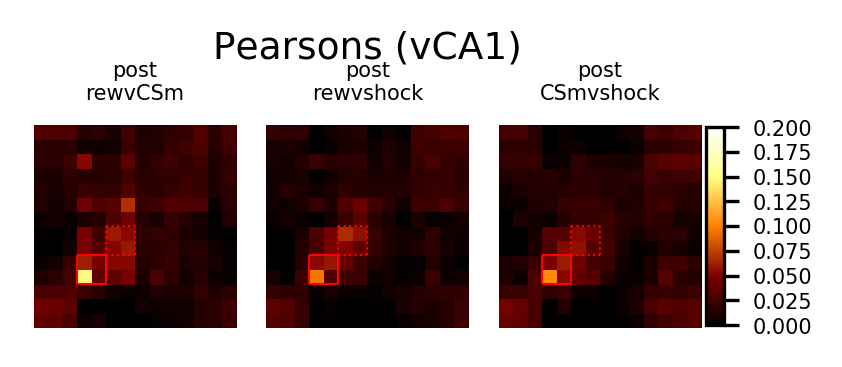

In [79]:
#importing seaborn below messes with this plot

fig,axs = pl.subplots(1,3,figsize=(2.4,1))
for sess,r in zip(sessions,range(len(sessions))):
    for trial,c in zip(['rewvCSm','rewvshock','CSmvshock'],[0,1,2]):
        im=axs[c].imshow(eval("allTs_big_matrix_1s_%s_%s"%(sess,trial)),origin='lower', aspect='equal', vmin=-0, vmax=0.2,cmap='afmhot')
        axs[c].set_title(sess+"\n"+trial,fontsize=5)
        axs[c].vlines(2.5,2.5,4.5,color='r')
        axs[c].hlines(2.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,2.5,4.5,color='r')
        axs[c].hlines(4.5,2.5,4.5,color='r')
        axs[c].vlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(4.5,4.5,6.5,color='r',linestyle=':')
        axs[c].vlines(6.5,4.5,6.5,color='r',linestyle=':')
        axs[c].hlines(6.5,4.5,6.5,color='r',linestyle=':')
        pt.remove_axes(axs[c])
pl.suptitle('Pearsons (vCA1)',y=1.1,fontsize=9)
cax = fig.add_axes([.97, 0.115, 0.025, 0.66])
pl.colorbar(im,cax=cax)

fig.tight_layout()
#fig.savefig("../img/%s.jpg"%NOTEBOOK_NAME)

In [40]:
save_workspace(db)

Could not store variable 'ip'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'math'. Skipping...
